In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import time

In [2]:
from pytorch_lightning.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    LearningRateMonitor,
)
import torch
from torch.nn import MSELoss
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import glob
from pathlib import Path

from src.data_models.camels_ch import CamelsCH, CamelsCHConfig, get_all_gauge_ids
from src.data_models.dataset import HydroDataset
from src.data_models.preprocessing import (
    scale_time_series,
    scale_static_attributes,
    inverse_scale_static_attributes,
    inverse_scale_time_series,
)
from src.data_models.caravanify import Caravanify, CaravanifyConfig

from utils.metrics import nash_sutcliffe_efficiency
from src.data_models.datamodule import HydroTransferDataModule, HydroDataModule

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from src.preprocessing.transformers import GroupedTransformer, LogTransformer

In [3]:
from src.models.lstm import LitLSTM
from src.models.ealstm import LitEALSTM
from src.models.TSMixer import LitTSMixer, TSMixerConfig
from src.models.TSMixerDomainAdaptation import LitTSMixerDomainAdaptation
from src.models.evaluators import TSForecastEvaluator
from torch.optim import Adam
from torch.nn import MSELoss

---

## Central Asia

In [4]:
# Configuration for loading Central Asian (CA) hydrology data
CA_config = CaravanifyConfig(
    attributes_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CA/post_processed/attributes",
    timeseries_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CA/post_processed/timeseries/csv",
    gauge_id_prefix="CA",
    use_hydroatlas_attributes=True,
    use_caravan_attributes=True,
    use_other_attributes=True,
)

# Initialize Caravan data loader and load first 3 stations for training
CA_caravan = Caravanify(CA_config)
ids_for_training = CA_caravan.get_all_gauge_ids()[:3]
print(f"Total number of stations: {len(ids_for_training)}")
CA_caravan.load_stations(ids_for_training)

# Get time series and static data
CA_ts_data = CA_caravan.get_time_series()
CA_static_data = CA_caravan.get_static_attributes()

# Process time series data
CA_ts_data["date"] = pd.to_datetime(CA_ts_data["date"])
CA_ts_data["julian_day"] = CA_ts_data["date"].dt.dayofyear

# Select relevant time series features
ts_columns = ["streamflow", "total_precipitation_sum"]
CA_ts_data = CA_ts_data[ts_columns + ["gauge_id", "date"]]

# Select relevant static features that characterize catchment properties
static_columns = [
    "gauge_id", "p_mean", "area", "ele_mt_sav", "high_prec_dur",
    "frac_snow", "high_prec_freq", "slp_dg_sav", "cly_pc_sav",
    "aridity_ERA5_LAND", "aridity_FAO_PM"
]
CA_static_data = CA_static_data[static_columns]

# Separate features from target variable
features = [col for col in CA_ts_data.columns if col not in ["gauge_id", "date", "streamflow"]]
ts_columns = features + ["streamflow"]

feature_pipeline = Pipeline([
    ("log", LogTransformer()), 
    ("scaler", StandardScaler())
])

target_pipeline = GroupedTransformer(
    Pipeline([("log", LogTransformer()), ("scaler", StandardScaler())]),
    columns=["streamflow"],
    group_identifier="gauge_id",
)

static_pipeline = Pipeline([("scaler", StandardScaler())])

preprocessing_configs = {
    "features": {"pipeline": feature_pipeline},
    "target": {"pipeline": target_pipeline},
    "static_features": {"pipeline": static_pipeline},
}

Total number of stations: 3


In [5]:
batch_size = 3
output_length = 10
input_length = 30
hidden_size = 15

# Create data module with the trial's batch size and input length
CA_data_module = HydroDataModule(
    time_series_df=CA_ts_data,
    static_df=CA_static_data,
    group_identifier="gauge_id",
    preprocessing_config=preprocessing_configs,
    batch_size=batch_size,  # Use trial's batch size
    input_length=input_length,  # Use trial's input length
    output_length=output_length,
    num_workers=4,
    features=ts_columns,
    static_features=static_columns,
    target="streamflow",
    min_train_years=2,
    val_years=1,
    test_years=3,
    max_missing_pct=10,
    domain_id="target",
)

CA_data_module.prepare_data()
CA_data_module.setup()

Original basins: 3
Retained basins: 2
Domain target: Created 13284 valid sequences from 2 catchments
Domain target: Created 652 valid sequences from 2 catchments
Domain target: Created 2114 valid sequences from 2 catchments


/Users/cooper/Desktop/CAMELS-CH/src/data_models/datamodule.py:354: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.processed_static[col] = transformed[:, i]


## Switzerland 

In [6]:
# Configuration for loading Central Asian (CA) hydrology data
CH_config = CaravanifyConfig(
    attributes_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CH/post_processed/attributes",
    timeseries_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CH/post_processed/timeseries/csv",
    gauge_id_prefix="CH",
    use_hydroatlas_attributes=True,
    use_caravan_attributes=True,
    use_other_attributes=True,
)

# Initialize Caravan data loader and load first 3 stations for training
CH_caravan = Caravanify(CH_config)
ids_for_training = CH_caravan.get_all_gauge_ids()[:3]
print(f"Total number of stations: {len(ids_for_training)}")
CH_caravan.load_stations(ids_for_training)

# Get time series and static data
CH_ts_data = CH_caravan.get_time_series()
CH_static_data = CH_caravan.get_static_attributes()

# Process time series data
CH_ts_data["date"] = pd.to_datetime(CH_ts_data["date"])
CH_ts_data["julian_day"] = CH_ts_data["date"].dt.dayofyear

# Select relevant time series features
ts_columns = ["streamflow", "total_precipitation_sum"]
CH_ts_data = CH_ts_data[ts_columns + ["gauge_id", "date"]]

# Select relevant static features that characterize catchment properties
static_columns = [
    "gauge_id", "p_mean", "area", "ele_mt_sav", "high_prec_dur",
    "frac_snow", "high_prec_freq", "slp_dg_sav", "cly_pc_sav",
    "aridity_ERA5_LAND", "aridity_FAO_PM"
]
CH_static_data = CH_static_data[static_columns]

# Separate features from target variable
features = [col for col in CH_ts_data.columns if col not in [
    "gauge_id", "date", "streamflow"]]
ts_columns = features + ["streamflow"]

# Define preprocessing pipelines:
# 1. Feature pipeline: Log transform followed by standardization
feature_pipeline = Pipeline([
    ("log", LogTransformer()),
    ("scaler", StandardScaler())
])

# 2. Target pipeline: Log transform and standardization per catchment
target_pipeline = GroupedTransformer(
    Pipeline([("log", LogTransformer()), ("scaler", StandardScaler())]),
    columns=["streamflow"],
    group_identifier="gauge_id",
)

# 3. Static feature pipeline: Only standardization needed
static_pipeline = Pipeline([("scaler", StandardScaler())])

# Combine all preprocessing configurations
preprocessing_configs = {
    "features": {"pipeline": feature_pipeline},
    "target": {"pipeline": target_pipeline},
    "static_features": {"pipeline": static_pipeline},
}

Total number of stations: 3


In [7]:
CH_data_module = HydroDataModule(
    time_series_df=CH_ts_data,
    static_df=CH_static_data,
    group_identifier="gauge_id",
    preprocessing_config=preprocessing_configs,
    batch_size=batch_size,  # Use trial's batch size
    input_length=input_length,  # Use trial's input length
    output_length=output_length,
    num_workers=4,
    features=ts_columns,
    static_features=static_columns,
    target="streamflow",
    min_train_years=2,
    val_years=1,
    test_years=3,
    max_missing_pct=10,
    domain_id="source",
)

CH_data_module.prepare_data()
CH_data_module.setup()



Original basins: 3
Retained basins: 3
Domain source: Created 39327 valid sequences from 3 catchments
Domain source: Created 978 valid sequences from 3 catchments
Domain source: Created 3171 valid sequences from 3 catchments


## Testing combined DataModule

In [8]:
# Create transfer datamodule
transfer_dm = HydroTransferDataModule(
    source_datamodule=CA_data_module,
    target_datamodule=CH_data_module,
    num_workers=4
)

# Setup and get training loader
transfer_dm.setup("fit")
train_loader = transfer_dm.train_dataloader()

for i, batch in enumerate(train_loader):
    if i >= 6:  # Look at first 6 batches
        break
    print(f"\nMixed Batch {i}:")
    print(f"X shape: {batch['X'].shape}")
    print(f"y shape: {batch['y'].shape}")
    print(f"static shape: {batch['static'].shape}")
    print(f"domain_id shape: {batch['domain_id'].shape}")

    print(f"Slice indeces: {batch['slice_idx']}")

    # Count samples from each domain using float tensor comparison
    source_samples = (batch['domain_id'] == 0.0).sum().item()
    target_samples = (batch['domain_id'] == 1.0).sum().item()

    print(f"Distribution:")
    print(f"- Source (CH): {source_samples} samples")
    print(f"- Target (CA): {target_samples} samples")
    print(f"- Total: {source_samples + target_samples} samples")

    # Print domain IDs
    print(f"Domain IDs: {list(batch['domain_id'])}")

    


Mixed Batch 0:
X shape: torch.Size([3, 30, 2])
y shape: torch.Size([3, 10])
static shape: torch.Size([3, 10])
domain_id shape: torch.Size([3, 1])
Slice indeces: [tensor([4867,  332, 9930]), tensor([4868,  333, 9931]), tensor([ 6210, 33155, 25791]), tensor([ 6211, 33156, 25792]), tensor([ 6212, 33157, 25793]), tensor([ 6213, 33158, 25794]), tensor([ 6214, 33159, 25795]), tensor([ 6215, 33160, 25796]), tensor([ 6216, 33161, 25797]), tensor([ 6217, 33162, 25798]), tensor([ 6218, 33163, 25799]), tensor([ 6219, 33164, 25800]), tensor([ 6220, 33165, 25801]), tensor([ 6221, 33166, 25802]), tensor([ 6222, 33167, 25803]), tensor([ 6223, 33168, 25804]), tensor([ 6224, 33169, 25805]), tensor([ 6225, 33170, 25806]), tensor([ 6226, 33171, 25807]), tensor([ 6227, 33172, 25808]), tensor([ 6228, 33173, 25809]), tensor([ 6229, 33174, 25810]), tensor([ 6230, 33175, 25811]), tensor([ 6231, 33176, 25812]), tensor([ 6232, 33177, 25813]), tensor([ 6233, 33178, 25814]), tensor([ 6234, 33179, 25815]), tensor

In [9]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

# 1. Initialize the model with domain adaptation
model = LitTSMixerDomainAdaptation(
    config=TSMixerConfig(
        input_len=input_length,
        output_len=output_length,
        input_size=2,
        static_size=10,
        hidden_size=hidden_size
    ),
    lambda_adv=1.0,
    domain_loss_weight=0.5,
    group_identifier="gauge_id",
)

trainer = pl.Trainer(
    max_epochs=1,
    accelerator="cpu",
    devices=1,
    callbacks=[EarlyStopping(monitor="val_loss", patience=3)],
    enable_progress_bar=True
)

trainer.fit(model, transfer_dm)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name                 | Type                | Params | Mode 
---------------------------------------------------------------------
0 | model                | TSMixer             | 39.6 K | train
1 | mse_criterion        | MSELoss             | 0      | train
2 | domain_discriminator | DomainDiscriminator | 126 K  | train
3 | domain_criterion     | BCELoss             | 0      | train
---------------------------------------------------------------------
166 K     Trainable params
0         Non-trainable params
166 K     Total params
0.666     Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [10]:
trainer.test(model, CA_data_module)
raw_results = model.test_results

# Create evaluator and get metrics
evaluator = TSForecastEvaluator(
    CA_data_module, horizons=list(range(1, model.config.output_len + 1))
)
results_df, overall_metrics, basin_metrics = evaluator.evaluate(raw_results)

# Get overall summary
overall_summary = evaluator.summarize_metrics(overall_metrics)

# Get per-basin summary
basin_summary = evaluator.summarize_metrics(basin_metrics, per_basin=True)

Original basins: 3
Retained basins: 2
Domain target: Created 2114 valid sequences from 2 catchments


/Users/cooper/Desktop/CAMELS-CH/src/data_models/datamodule.py:354: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.processed_static[col] = transformed[:, i]


Testing: |          | 0/? [00:00<?, ?it/s]

/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.16808149218559265
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


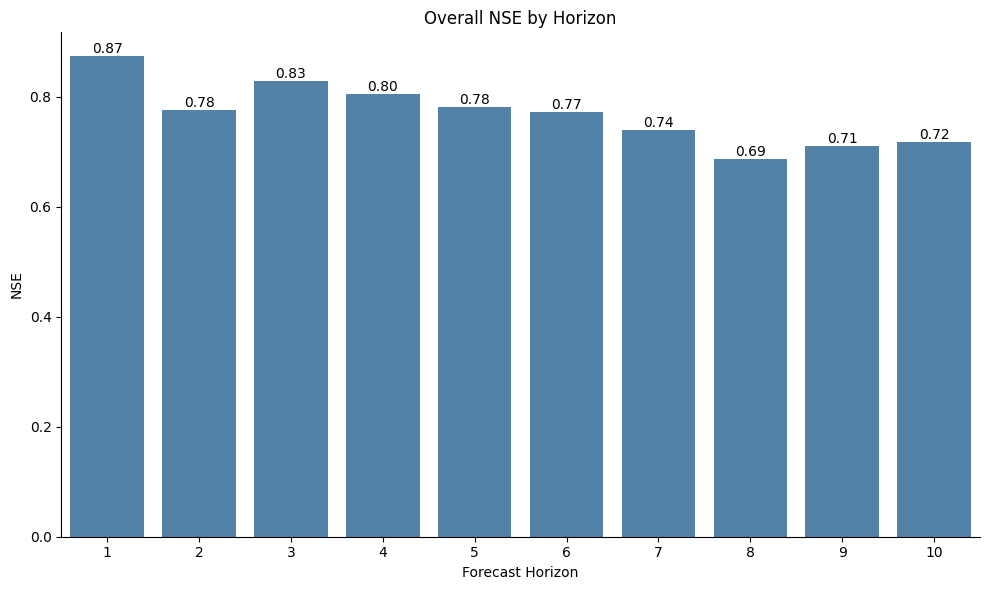

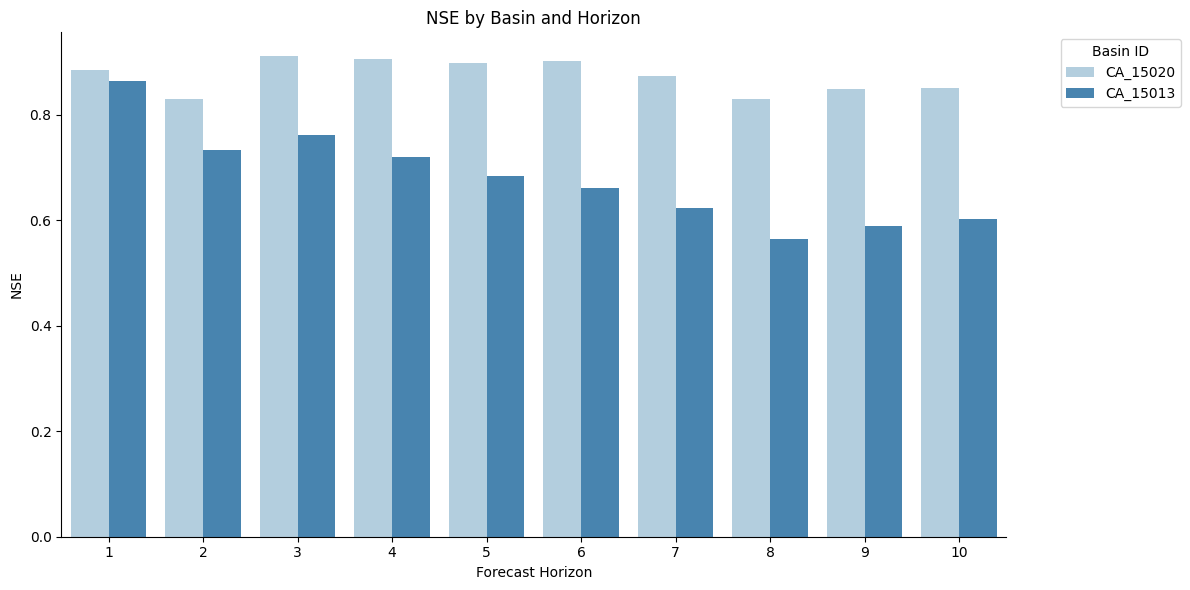

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_metric_summary(
    summary_df: pd.DataFrame, metric: str, per_basin: bool = False, figsize=(10, 6)
):
    plt.figure(figsize=figsize)

    if per_basin:
        df_plot = summary_df[metric].unstack(level=0)

        # Sort basins based on first horizon values
        first_horizon_values = df_plot.iloc[0]
        sorted_basins = first_horizon_values.sort_values(ascending=False).index
        df_plot = df_plot[sorted_basins]

        sns.barplot(
            data=df_plot.melt(ignore_index=False).reset_index(),
            x="horizon",
            y="value",
            hue="basin_id",
            palette="Blues",
        )
        plt.title(f"{metric} by Basin and Horizon")
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Basin ID")

    else:
        ax = sns.barplot(x=summary_df.index, y=summary_df[metric], color="steelblue")
        plt.title(f"Overall {metric} by Horizon")

        for i, v in enumerate(summary_df[metric]):
            ax.text(i, v, f"{v:.2f}", ha="center", va="bottom")

    plt.xlabel("Forecast Horizon")
    plt.ylabel(metric)
    plt.tight_layout()
    sns.despine()
    plt.show()


# Usage example:
plot_metric_summary(overall_summary, "NSE")  # Plot overall NSE
plot_metric_summary(
    basin_summary, "NSE", per_basin=True, figsize=(12, 6)
)  

## Now with lambda set to 0

In [12]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

# 1. Initialize the model with domain adaptation
model = LitTSMixerDomainAdaptation(
    config=TSMixerConfig(
        input_len=input_length,
        output_len=output_length,
        input_size=2,
        static_size=10,
        hidden_size=hidden_size
    ),
    lambda_adv=0.0,
    domain_loss_weight=0.0,
    group_identifier="gauge_id",
)

trainer = pl.Trainer(
    max_epochs=1,
    accelerator="cpu",
    devices=1,
    callbacks=[EarlyStopping(monitor="val_loss", patience=3)],
    enable_progress_bar=True
)

trainer.fit(model, transfer_dm)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name                 | Type                | Params | Mode 
---------------------------------------------------------------------
0 | model                | TSMixer             | 39.6 K | train
1 | mse_criterion        | MSELoss             | 0      | train
2 | domain_discriminator | DomainDiscriminator | 126 K  | train
3 | domain_criterion     | BCELoss             | 0      | train
---------------------------------------------------------------------
166 K     Trainable params
0         Non-trainable params
166 K     Total params
0.666     Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [13]:
trainer.test(model, CA_data_module)
raw_results = model.test_results

# Create evaluator and get metrics
evaluator = TSForecastEvaluator(
    CA_data_module, horizons=list(range(1, model.config.output_len + 1))
)
results_df, overall_metrics, basin_metrics = evaluator.evaluate(raw_results)

# Get overall summary
overall_summary = evaluator.summarize_metrics(overall_metrics)

# Get per-basin summary
basin_summary = evaluator.summarize_metrics(basin_metrics, per_basin=True)

Original basins: 3
Retained basins: 2
Domain target: Created 2114 valid sequences from 2 catchments


/Users/cooper/Desktop/CAMELS-CH/src/data_models/datamodule.py:354: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.processed_static[col] = transformed[:, i]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.14508730173110962
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


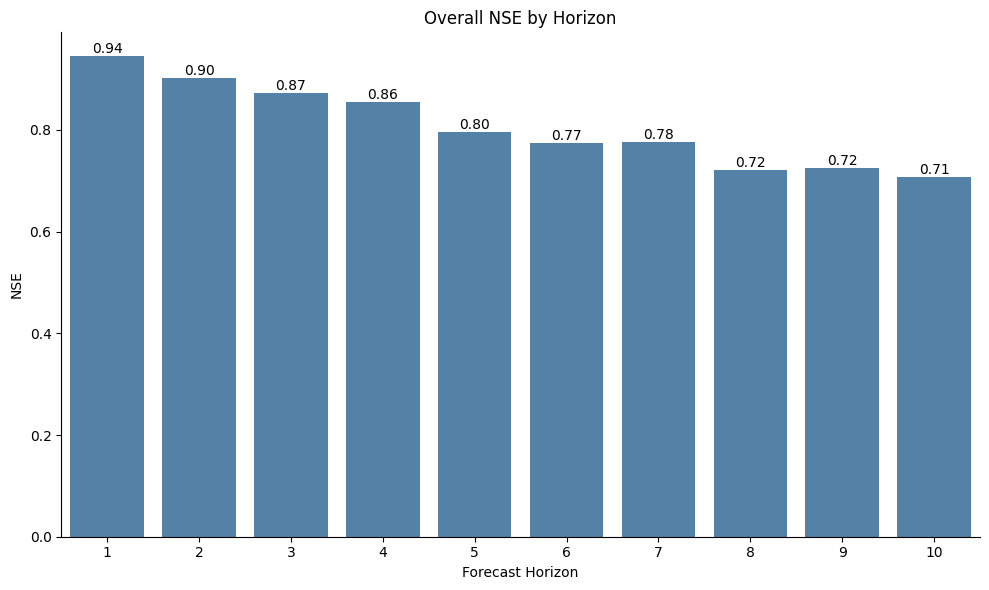

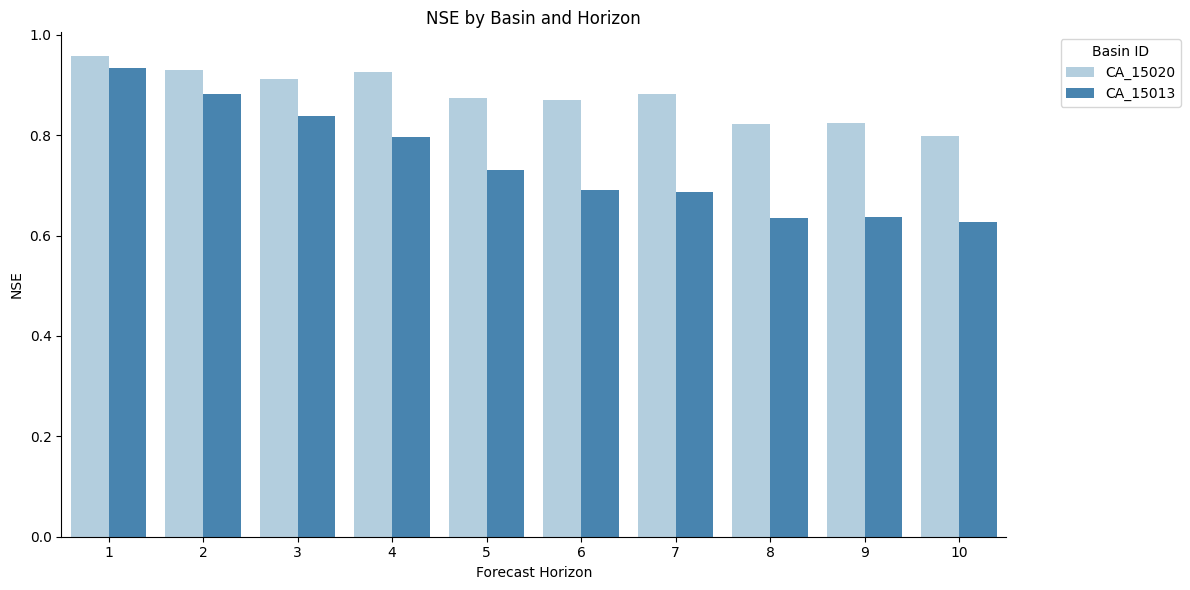

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_metric_summary(
    summary_df: pd.DataFrame, metric: str, per_basin: bool = False, figsize=(10, 6)
):
    plt.figure(figsize=figsize)

    if per_basin:
        df_plot = summary_df[metric].unstack(level=0)

        # Sort basins based on first horizon values
        first_horizon_values = df_plot.iloc[0]
        sorted_basins = first_horizon_values.sort_values(ascending=False).index
        df_plot = df_plot[sorted_basins]

        sns.barplot(
            data=df_plot.melt(ignore_index=False).reset_index(),
            x="horizon",
            y="value",
            hue="basin_id",
            palette="Blues",
        )
        plt.title(f"{metric} by Basin and Horizon")
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Basin ID")

    else:
        ax = sns.barplot(x=summary_df.index, y=summary_df[metric], color="steelblue")
        plt.title(f"Overall {metric} by Horizon")

        for i, v in enumerate(summary_df[metric]):
            ax.text(i, v, f"{v:.2f}", ha="center", va="bottom")

    plt.xlabel("Forecast Horizon")
    plt.ylabel(metric)
    plt.tight_layout()
    sns.despine()
    plt.show()


# Usage example:
plot_metric_summary(overall_summary, "NSE")  # Plot overall NSE
plot_metric_summary(
    basin_summary, "NSE", per_basin=True, figsize=(12, 6)
)  